In [38]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from CNN_helper_function import get_labels, eval_model

warnings.filterwarnings('ignore')

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D

from tensorflow.keras.models import load_model

print(f"Tensorflow Version: {tf.__version__}")

# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

seed = 42
tf.random.set_seed(seed)

Tensorflow Version: 2.15.0


In [2]:
# # Run this cell if you want to delete existing folder with the same name

# dir_path = 'EFlow Images/data' #Path of the directory to delete

# # Check if the directory exists
# if os.path.exists(dir_path) and os.path.isdir(dir_path):
#     # Delete the directory and all its contents
#     shutil.rmtree(dir_path)
#     print(f'Directory {dir_path} has been deleted.')
# else:
#     print(f'Directory {dir_path} does not exist.')


# Helper Functions

In [44]:
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score, 
#     auc, roc_curve, precision_recall_curve, confusion_matrix, 
#     det_curve, DetCurveDisplay, class_likelihood_ratios
# )
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# def get_labels(model, dataset) -> (list, list):
#     """
#     Given a trained model and a dataset, returns the true labels and model-predicted probabilities.

#     Parameters:
#     model (tf.keras.Model): Trained TensorFlow model.
#     dataset (tf.data.Dataset or tuple): Either a tf.data.Dataset or (X, y) tuple.

#     Returns:
#     tuple: (true_labels, predicted_probs), where both are lists.
#     """
#     true_labels = []
#     predicted_probs = []

#     # Check dataset format
#     if isinstance(dataset, tuple):
#         X, y = dataset  # Assume (features, labels) tuple
#         true_labels = list(y)
#         predicted_probs = list(model.predict(X, verbose=0).flatten())
#     else:
#         for batch in dataset:  # tf.data.Dataset
#             X_batch, y_batch = batch
#             true_labels.extend(y_batch.numpy())
#             predicted_probs.extend(model.predict(X_batch, verbose=0).flatten())

#     return true_labels, predicted_probs


# def eval_model(y_true:list[float], y_pred_prob:list[float], y_pred_label:list[float],*, save_fig:bool = False, save_fig_path:str = None) -> None:
#     """
#     Evaluate the model's performance using various classification metrics and visualization.

#     Parameters:
#     - y_true (array-like): True class labels.
#     - y_pred_prob (array-like): Predicted probabilities for the positive class.
#     - y_pred_label (array-like): Predicted class labels.
#     - save_fig (bool): If set to True then figure will be saved to specified filepath.
#     - save_fig_path (str): Filepath where to save the figure.

#     Displays metrics such as accuracy, precision, recall, F1-score, and likelihood ratios,
#     and plots the ROC curve, Precision-Recall curve, confusion matrix heatmap, and prediction histogram.
#     """
#     accuracy = accuracy_score(y_true, y_pred_label)
#     precision = precision_score(y_true, y_pred_label)
#     recall = recall_score(y_true, y_pred_label)
#     f1 = f1_score(y_true, y_pred_label)
#     conf_matrix = confusion_matrix(y_true, y_pred_label)
#     pos_LR, neg_LR = class_likelihood_ratios(y_true, y_pred_label)

#     figure, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
#     figure.suptitle("Model Evaluation Metrics", fontsize=16)

#     # --- Metrics Table (0,0) ---
#     ax[0,0].axis('off')
#     metrics = [
#         ['Positive LR', f"{pos_LR:.3f}"],
#         ['Negative LR', f"{neg_LR:.3f}"],
#         ['Accuracy', f"{accuracy:.3f}"],
#         ['Precision', f"{precision:.3f}"],
#         ['Recall', f"{recall:.3f}"],
#         ['F1-Score', f"{f1:.3f}"]
#     ]
    
#     table = ax[0,0].table(
#         cellText=metrics,
#         colLabels=['Metric', 'Value'],
#         cellLoc='center',
#         loc='center',
#         colColours=['#f0f0f0', '#f0f0f0']
#     )
    
#     table.auto_set_font_size(False)
#     table.set_fontsize(12)
#     table.scale(1, 1.5)

#     # --- ROC Curve (0, 1) ---
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
#     roc_auc = auc(fpr, tpr)
#     ax[0, 1].plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
#     ax[0, 1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
#     ax[0, 1].set_xlabel("False Positive Rate")
#     ax[0, 1].set_ylabel("True Positive Rate")
#     ax[0, 1].set_title('ROC Curve')
#     ax[0, 1].legend(loc="lower right")
#     ax[0, 1].grid(alpha=0.3)


#     # --- Confusion Matrix (2,1) ---
#     group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
#     group_percentage = np.array([np.round((row/total)*100, 2) for row, total in zip(conf_matrix, np.sum(conf_matrix, axis=1))]).flatten()
#     labels = np.asarray([f"{counts}\n{percent}%" for counts, percent in zip(group_counts, group_percentage)]).reshape((2, 2))
#     sns.heatmap(conf_matrix, annot=labels, fmt='', ax=ax[1, 0])
#     ax[1, 0].set_xlabel("Predicted Labels")
#     ax[1, 0].set_ylabel("True Labels")
#     ax[1, 0].set_title("Confusion Matrix Heatmap")

#     # --- Predicted Probabilities Histogram(2,2) ---
#     ax[1, 1].hist(y_pred_prob, histtype='step', linewidth=2, label="Model's Prediction")
#     ax[1, 1].hist(y_true, histtype='step', color='green', linewidth=2, label="Actual Labels", alpha=0.4)
#     ax[1, 1].set_xlabel('Predicted Probabilities')
#     ax[1, 1].set_ylabel('Frequency')
#     ax[1, 1].set_title('Predicted Probabilities Histogram')
#     ax[1, 1].legend()
    
#     plt.tight_layout()
#     if save_fig & (save_fig_path != None):
#         plt.savefig(save_fig_path, bbox_inches = 'tight', pad_inches = 0.05)
#         print(f"Figure saved to {save_fig_path} successfully :)")
    
#     plt.show()
    
#     return None

# 0. Extracting the zip files

In [4]:
os.getcwd()

'/teamspace/studios/this_studio/all/EFlow Images/Notebooks'

In [5]:
# folder_path = '/teamspace/studios/this_studio/all/EFlow Images'


# #Extracting the zip files
# parent_data_path = '/teamspace/studios/this_studio/all/EFlow Images/rgb_images_data' #Creating new directory for extracting the images

# for zipName in os.listdir(folder_path):
#     zip_path = os.path.join(folder_path, zipName)
    
#     if zipName[-4:] != '.zip':
#         continue
    
#     print(f'Extracting: {zipName}...')

#     extract_path = os.path.join(parent_data_path, zipName[:-4])
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         for member in zip_ref.namelist():
#             if member.endswith('.png'):
#                 #print(member)
#                 zip_ref.extract(member, extract_path)
    
#     print(f'----Extraction of {zipName} Completed----\n')
#     print(100*'~')


# 1. Data Loading

Found 19675 files belonging to 2 classes.


2025-02-02 11:21:31.689617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:21:31.689870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-02 11:21:31.690012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

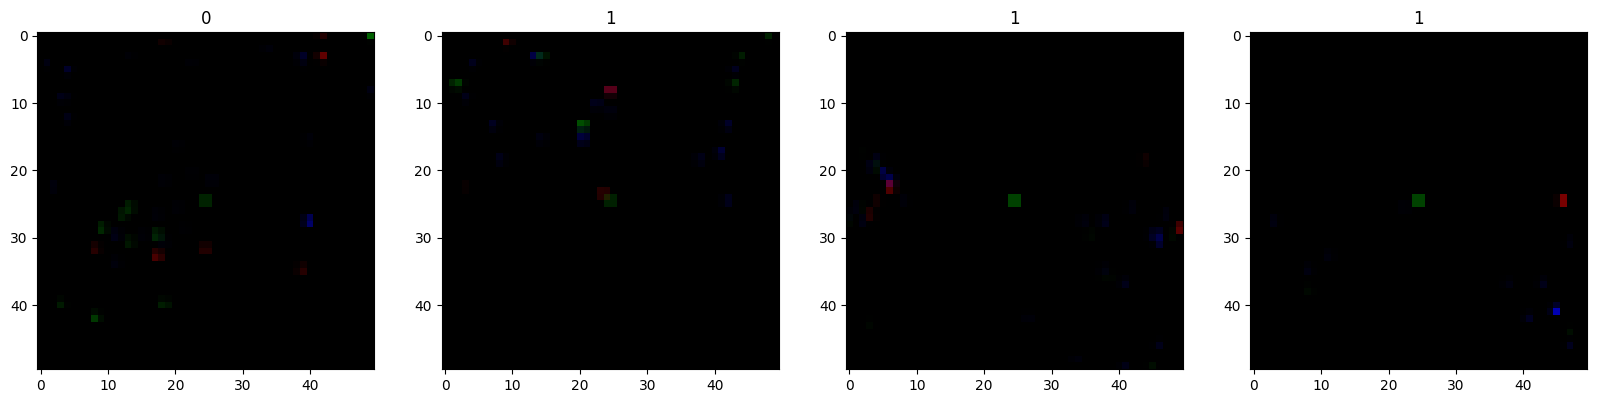

In [6]:
data_dir = '/teamspace/studios/this_studio/all/EFlow Images/rgb_images_data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 70,
                                                   image_size = (50,50))

scaled_data = data.map(lambda x, y: (x/255, y))

data_iterator = scaled_data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 2. Data Splitting

In [7]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [8]:
len(test)

28

# 3. CNN Model 1

In [9]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D()) #2x2 filter

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 16)          0

# 4. Training

In [10]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/EFLow_Images_CNN_Classifier_model1'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train,
                 epochs = 20,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/20


2025-02-02 11:21:45.776877: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-02-02 11:21:48.204281: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7df813e9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-02 11:21:48.204315: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-02 11:21:48.226836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738495308.382192    8264 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 [==============================] - 8s 12ms/step - loss: 0.6847 - accuracy: 0.5833 - precision: 0.5957 - recall: 0.4945 - auc: 0.6076 - true_positives: 3378.0000 - false_positives: 2293.0000 - true_negatives: 4666.0000 - false_negatives: 3453.0000 - val_loss: 0.6459 - val_accuracy: 0.5972 - val_precision: 0.6171 - val_recall: 0.5876 - val_auc: 0.6570 - val_true_positives: 1194.0000 - val_false_positives: 741.0000 - val_true_negatives: 1147.0000 - val_false_negatives: 838.0000
Epoch 2/20
197/197 [==============================] - 2s 10ms/step - loss: 0.6360 - accuracy: 0.6282 - precision: 0.6540 - recall: 0.5298 - auc: 0.6786 - true_positives: 3619.0000 - false_positives: 1915.0000 - true_negatives: 5044.0000 - false_negatives: 3212.0000 - val_loss: 0.6326 - val_accuracy: 0.6334 - val_precision: 0.7190 - val_recall: 0.4674 - val_auc: 0.6945 - val_true_positives: 939.0000 - val_false_positives: 367.0000 - val_true_negatives: 1544.0000 - val_false_negatives: 1070.0000
Epoch 3/20
19

In [11]:
# model.save(os.path.join('EFlow Images','Eflowimageclassifier1.keras'))

# 5. Performance Metrices

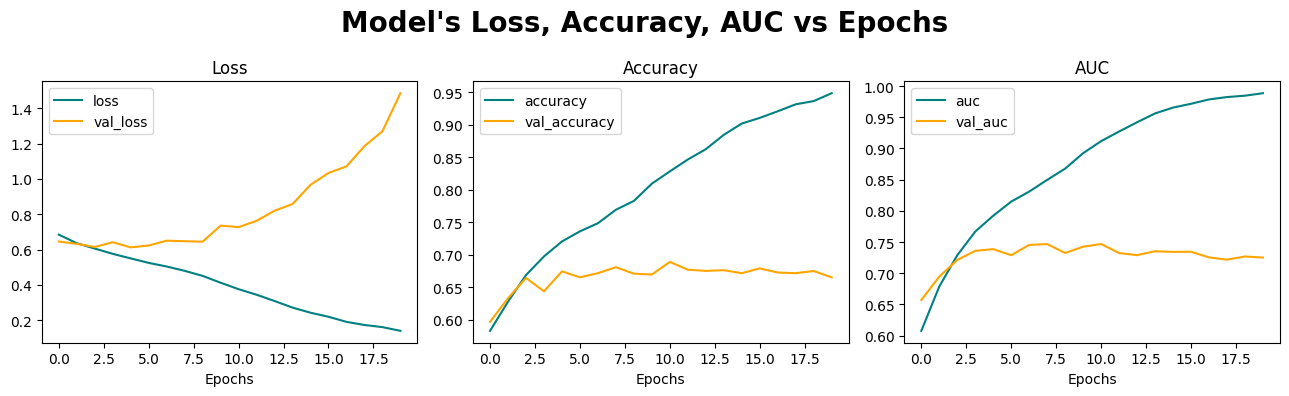

In [12]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist.history['auc'], color='teal', label='auc')
axs[2].plot(hist.history['val_auc'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('CNNClassifier_model1_trainingMetrics.png', dpi = 300)
plt.show()

# 6. Testing

In [13]:
test_data = test.as_numpy_iterator()
test_batch = test_data.next()

In [14]:
test_evaluate = model.evaluate(test)

28/28 [==============================] - 1s 5ms/step - loss: 1.6019 - accuracy: 0.6485 - precision: 0.7177 - recall: 0.5080 - auc: 0.6949 - true_positives: 506.0000 - false_positives: 199.0000 - true_negatives: 765.0000 - false_negatives: 490.0000


In [15]:
print(f"Best Obtained Loss: {hist.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.13991838693618774
Best Obtained Accuracy: 94.86%
Best Obtained Validation Accuracy: 66.56%


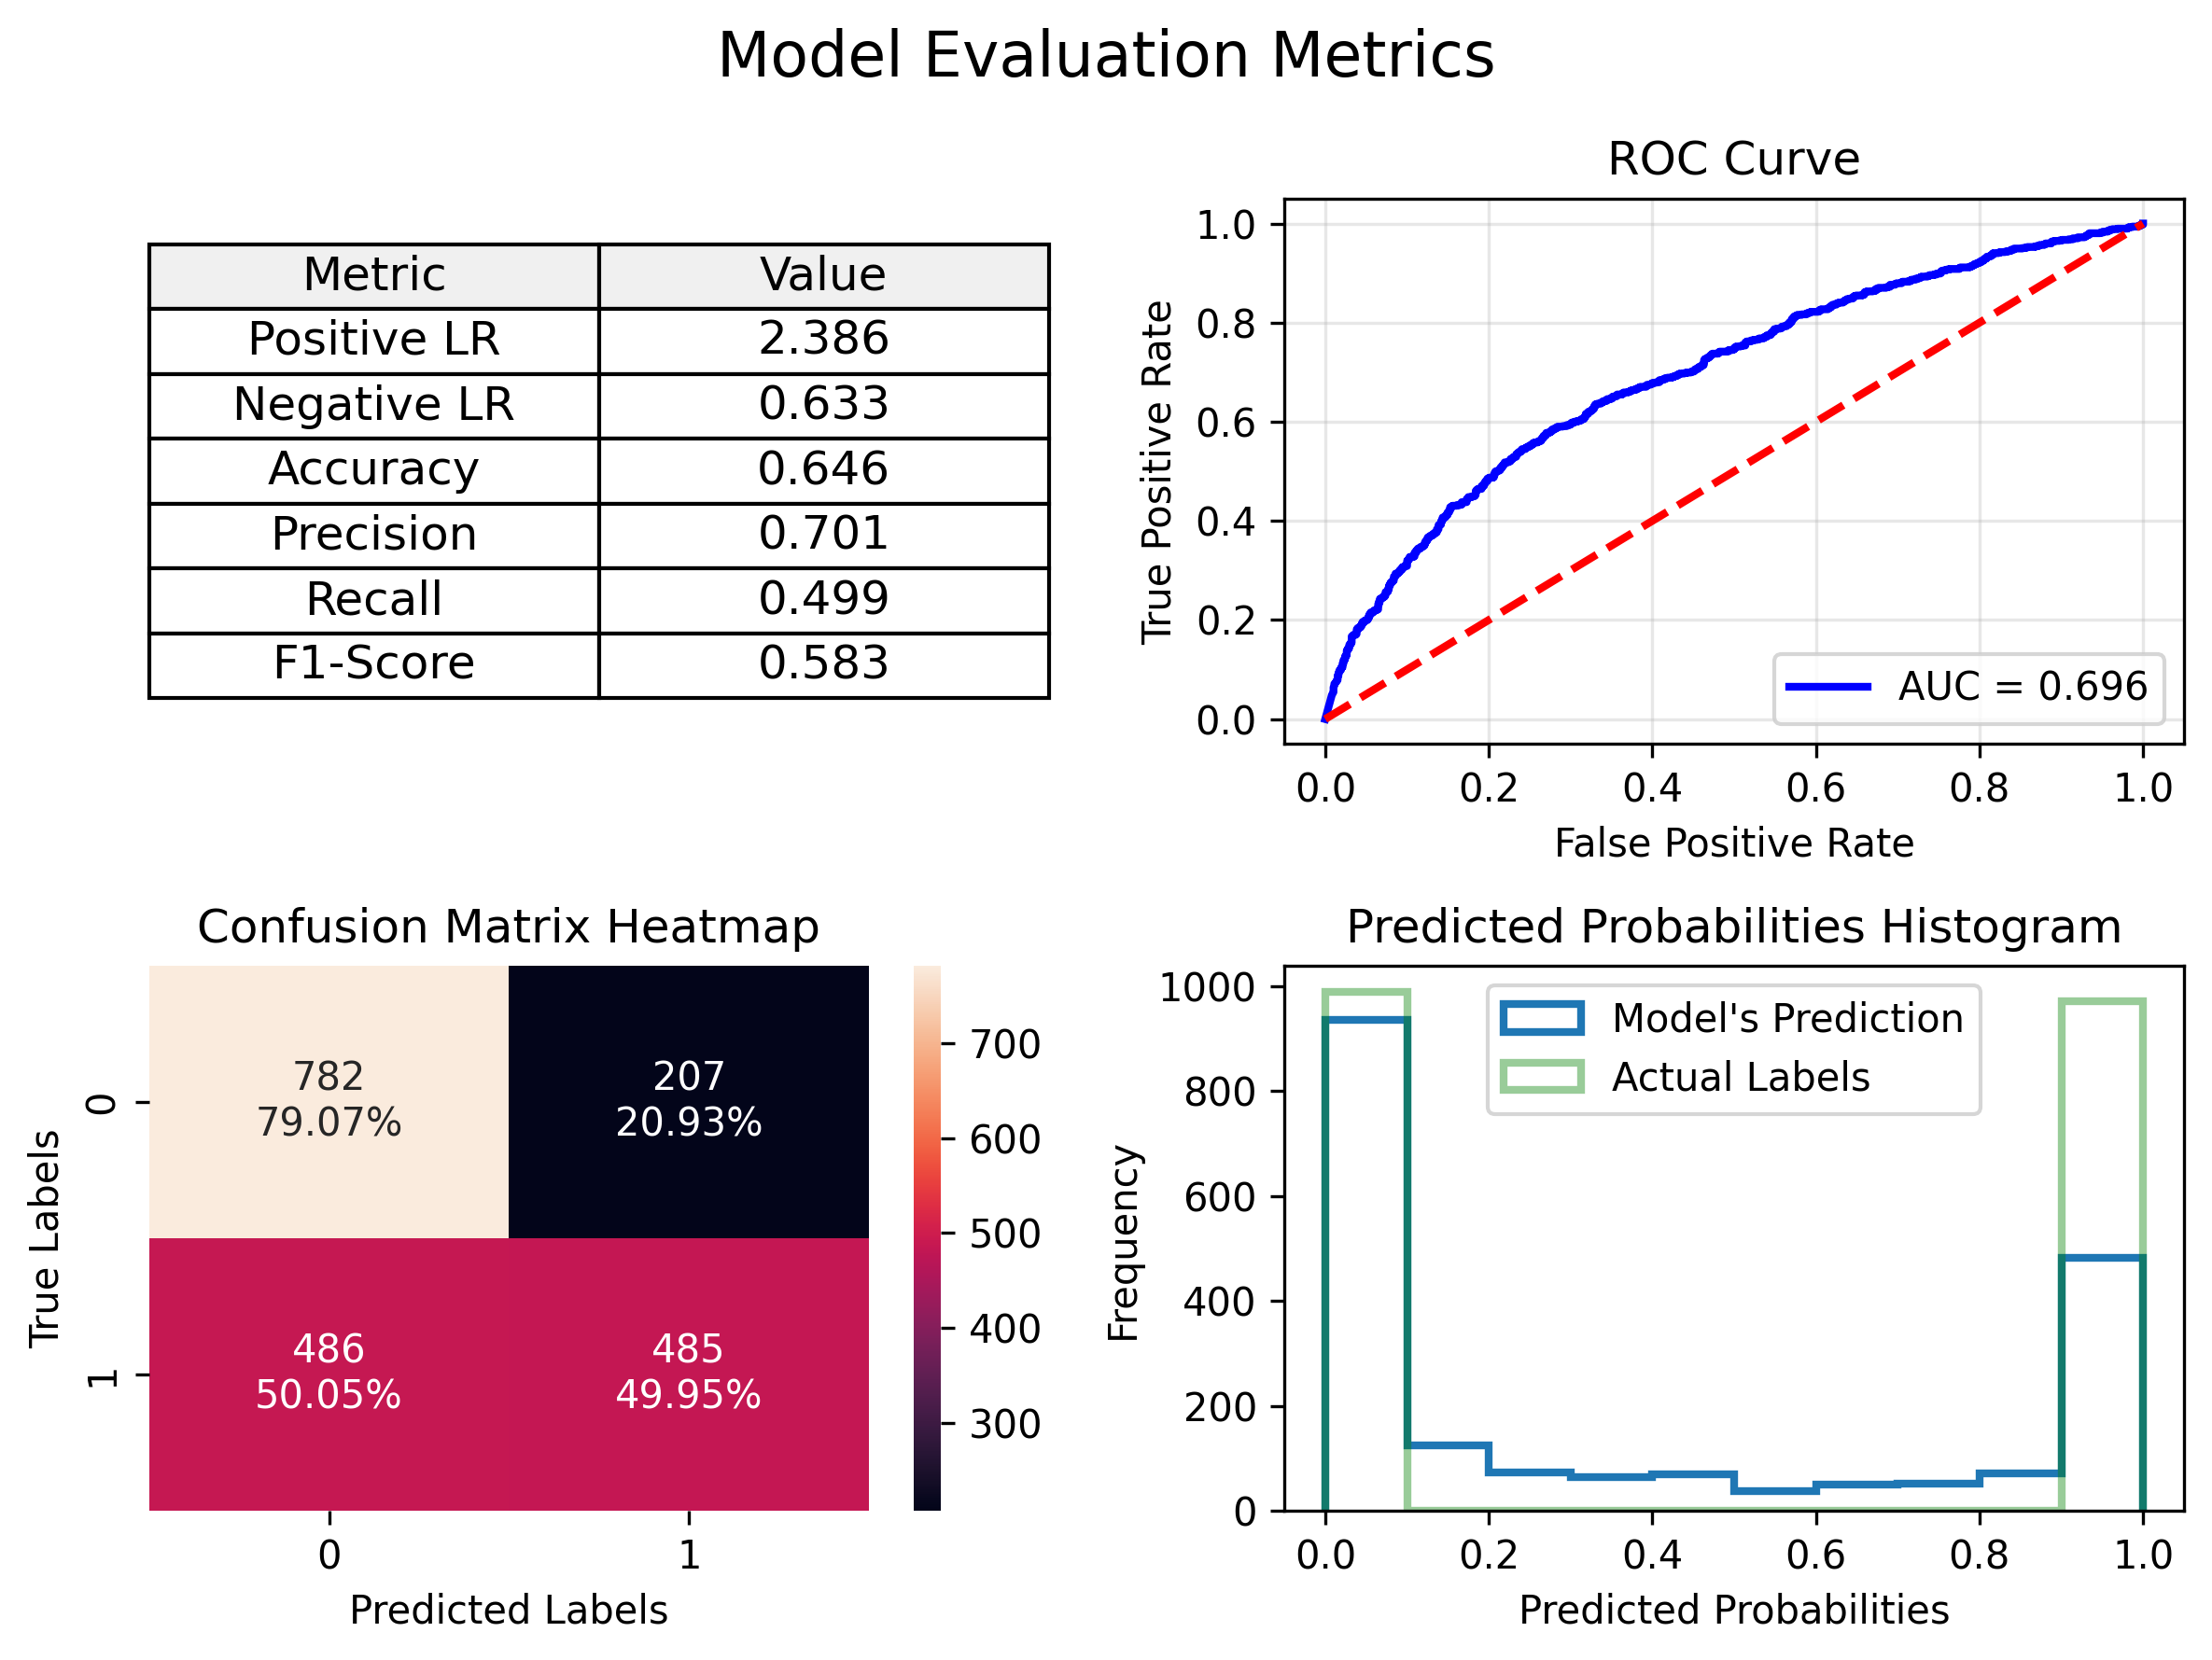

In [48]:
y_test_true, y_test_pred_prob = get_labels(model, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'CNNModel1_Metrics.png')

# Model 2: With 2 additional Convolution Layers

In [16]:
model2 = Sequential()

model2.add(Conv2D(128, (3,3), 1, activation='relu', input_shape=(50,50,3)))
model2.add(MaxPooling2D(strides=1)) #2x2 filter

model2.add(Conv2D(64, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D(strides=1,
                        padding='same'))

model2.add(Conv2D(16, (2,2), 1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(8, (2,2), 1, activation='relu'))
#model2.add(MaxPooling2D())

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [17]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 20, 20, 32)       

In [18]:
model2.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

## Model 2: Training

In [19]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/EFLow_Images_CNN_Classifier_model2'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist2 = model2.fit(train,
                 epochs = 20,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/20
197/197 [==============================] - 9s 27ms/step - loss: 0.6647 - accuracy: 0.6002 - precision_1: 0.6164 - recall_1: 0.5075 - auc_1: 0.6308 - true_positives_1: 3461.0000 - false_positives_1: 2154.0000 - true_negatives_1: 4816.0000 - false_negatives_1: 3359.0000 - val_loss: 0.6392 - val_accuracy: 0.6224 - val_precision_1: 0.6278 - val_recall_1: 0.6673 - val_auc_1: 0.6814 - val_true_positives_1: 1356.0000 - val_false_positives_1: 804.0000 - val_true_negatives_1: 1084.0000 - val_false_negatives_1: 676.0000
Epoch 2/20
197/197 [==============================] - 5s 26ms/step - loss: 0.6257 - accuracy: 0.6598 - precision_1: 0.6935 - recall_1: 0.5630 - auc_1: 0.7074 - true_positives_1: 3851.0000 - false_positives_1: 1702.0000 - true_negatives_1: 5248.0000 - false_negatives_1: 2989.0000 - val_loss: 0.6069 - val_accuracy: 0.6740 - val_precision_1: 0.7208 - val_recall_1: 0.5986 - val_auc_1: 0.7356 - val_true_positives_1: 1208.0000 - val_false_positives_1: 468.0000 - val_true_neg

In [20]:
#Saving the model
# model2.save(os.path.join('EFlow Images','Eflowimageclassifier2.keras'))

## Model 2: Performance Metrices

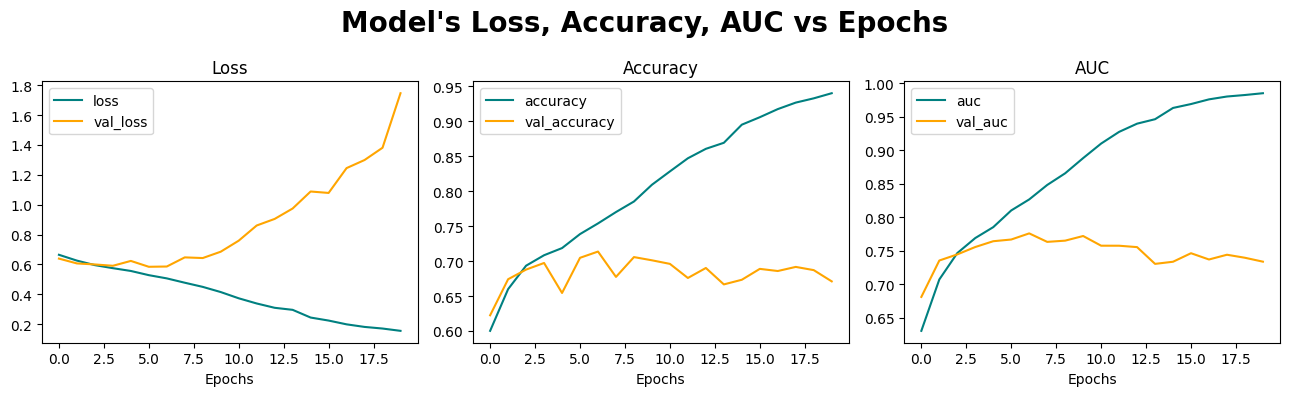

In [21]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist2.history['loss'], color='teal', label='loss')
axs[0].plot(hist2.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist2.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist2.history['auc_1'], color='teal', label='auc')
axs[2].plot(hist2.history['val_auc_1'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('CNNClassifier_model1_trainingMetrics.png', dpi = 300)
plt.show()

## Model 2: Testing

In [22]:
test_evaluate_model2 = model2.evaluate(test)

28/28 [==============================] - 1s 8ms/step - loss: 1.9290 - accuracy: 0.6510 - precision_1: 0.6214 - recall_1: 0.7641 - auc_1: 0.7095 - true_positives_1: 745.0000 - false_positives_1: 454.0000 - true_negatives_1: 531.0000 - false_negatives_1: 230.0000


**NOT so Significant increase in the Accuracy by increasing the number of layers**

In [23]:
print(f"Best Obtained Loss: {hist2.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist2.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist2.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.1555657982826233
Best Obtained Accuracy: 93.98%
Best Obtained Validation Accuracy: 67.09%


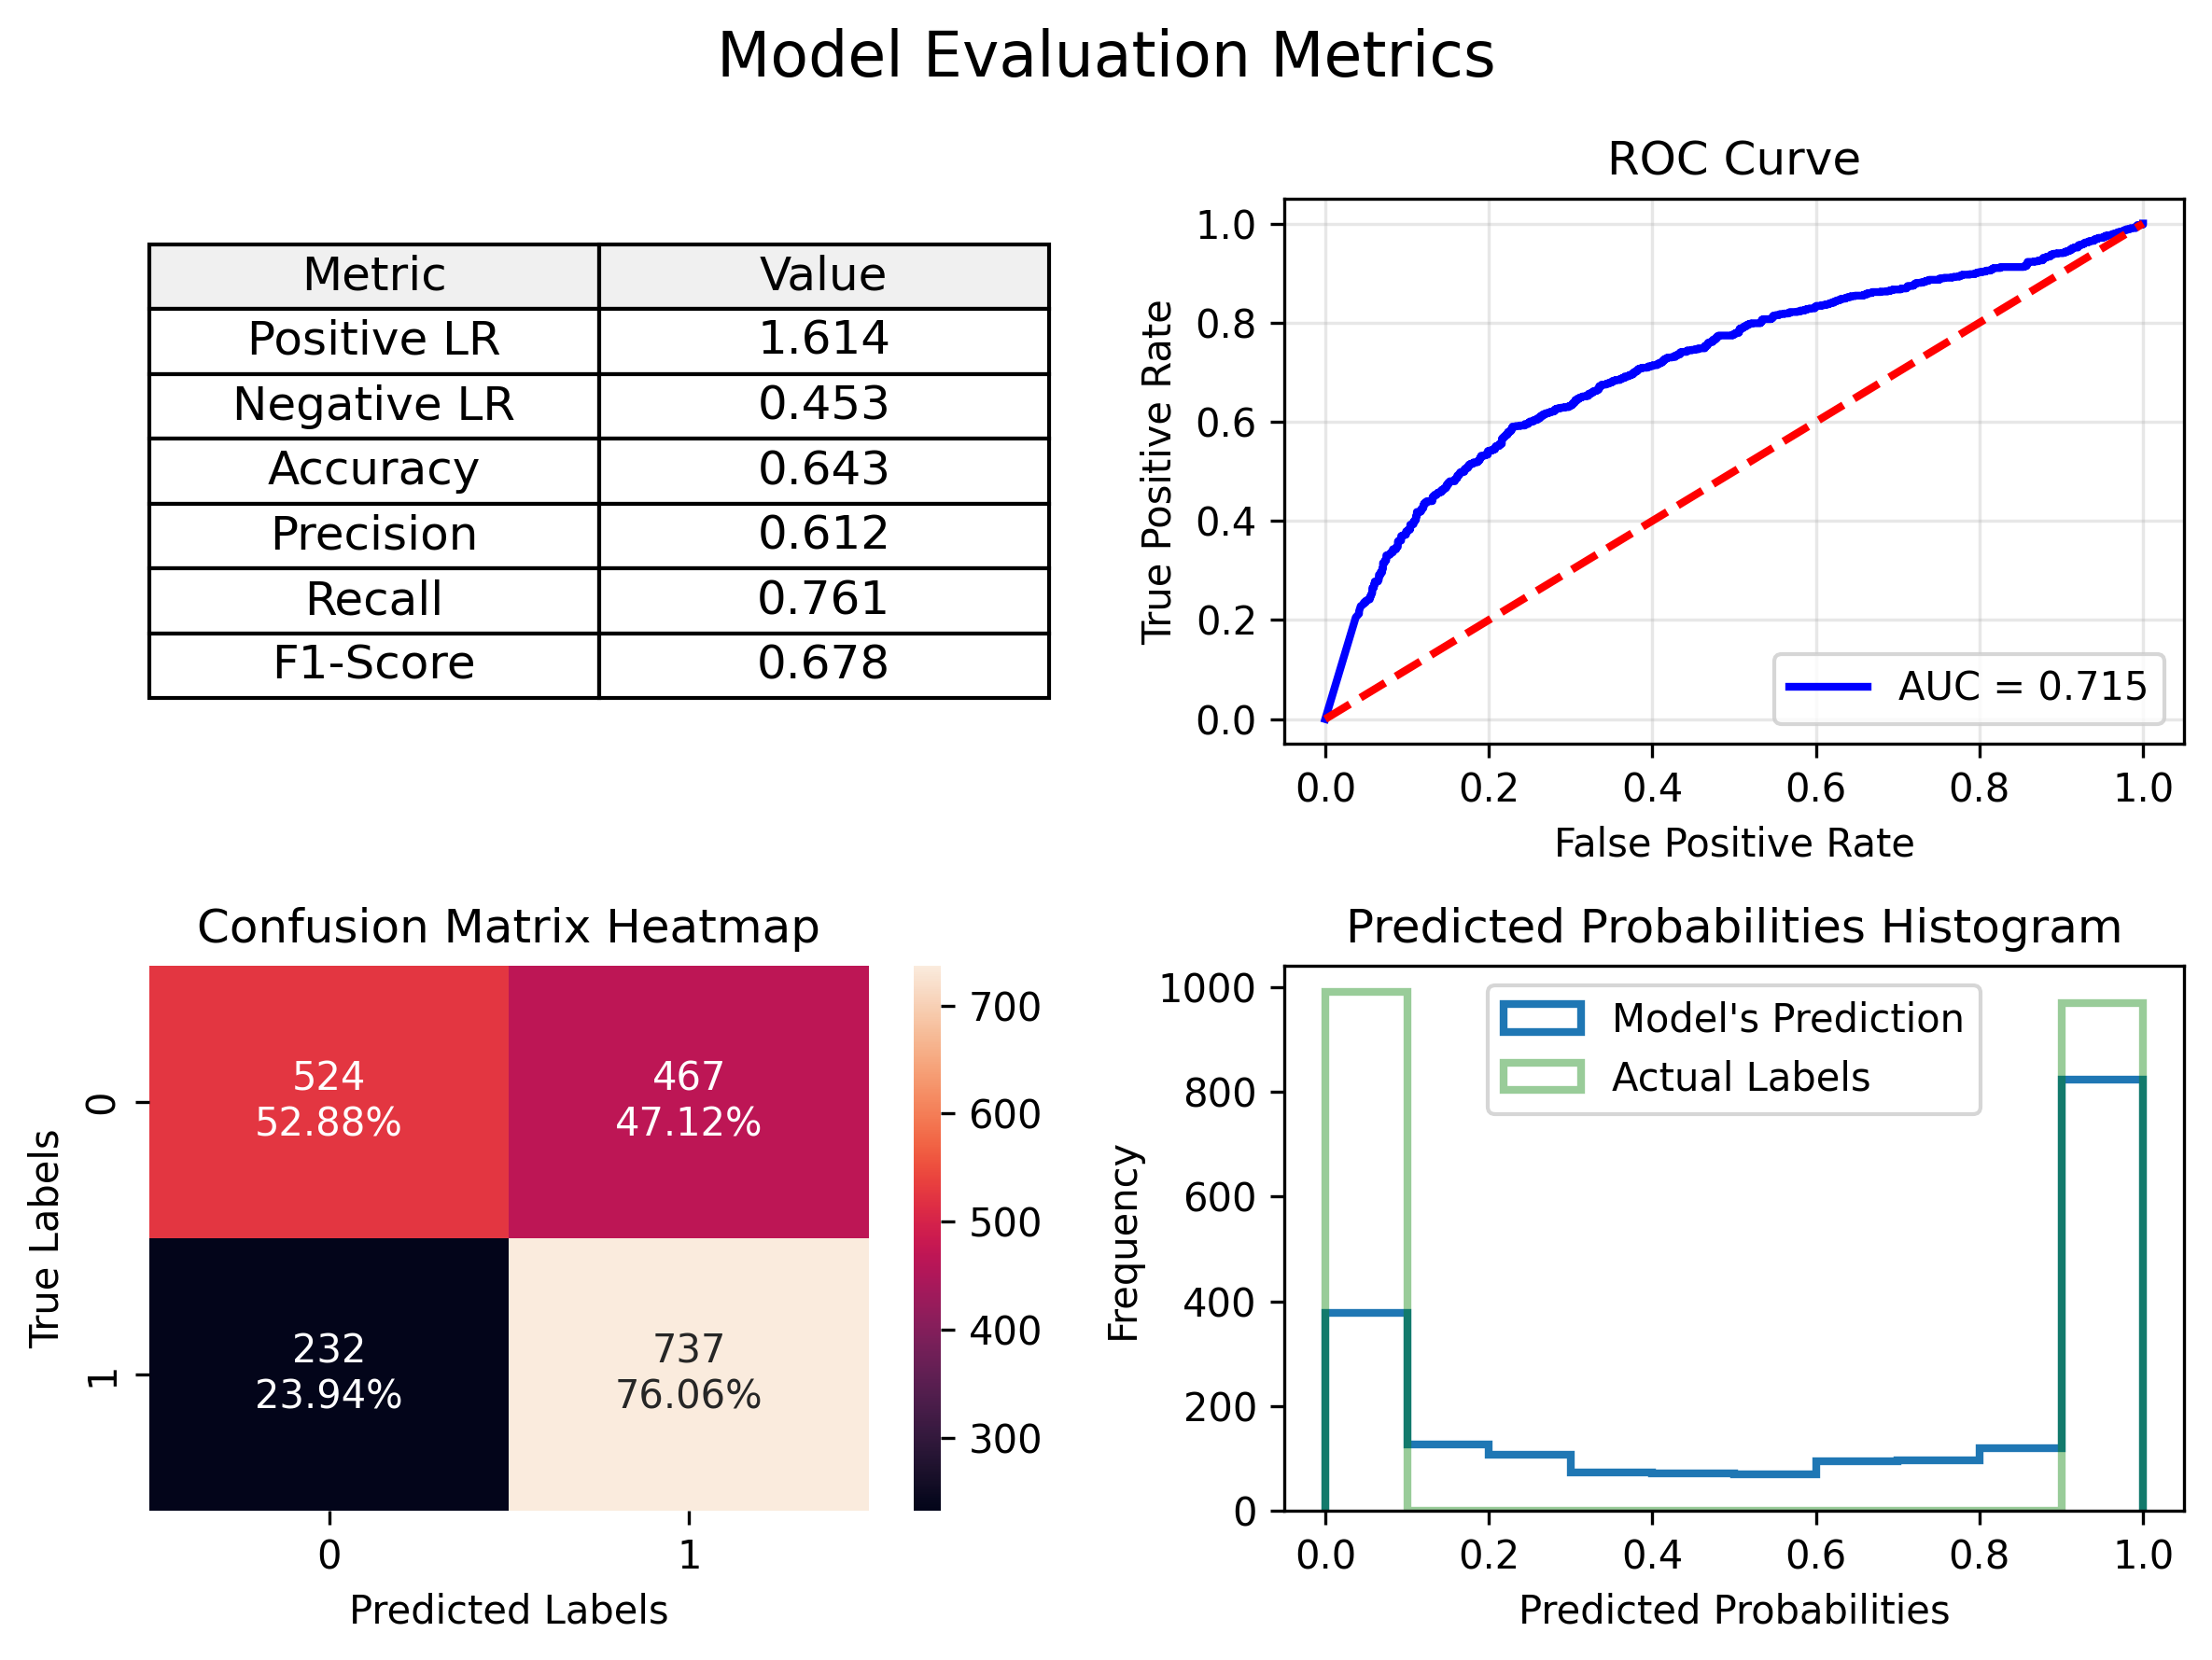

In [51]:
y_test_true, y_test_pred_prob = get_labels(model2, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'CNNModel2_Metrics.png')

# Model 3: With AveragePooling

In [24]:
model3 = Sequential()

model3.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
model3.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model3.add(Conv2D(64, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(32, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model3.add(Conv2D(16, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(8, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [25]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       9728      
                                                                 
 average_pooling2d (Average  (None, 49, 49, 128)       0         
 Pooling2D)                                                      
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        73792     
                                                                 
 average_pooling2d_1 (Avera  (None, 23, 23, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 32)        18464     
                                                                 
 average_pooling2d_2 (Avera  (None, 21, 21, 32)       

In [26]:
model3.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [27]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/EFLow_Images_CNN_Classifier_model3'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist3 = model3.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30
197/197 [==============================] - 10s 30ms/step - loss: 0.6633 - accuracy: 0.5916 - precision_2: 0.6024 - recall_2: 0.5185 - auc_2: 0.6281 - true_positives_2: 3545.0000 - false_positives_2: 2340.0000 - true_negatives_2: 4613.0000 - false_negatives_2: 3292.0000 - val_loss: 0.6347 - val_accuracy: 0.6495 - val_precision_2: 0.7178 - val_recall_2: 0.5248 - val_auc_2: 0.7006 - val_true_positives_2: 1058.0000 - val_false_positives_2: 416.0000 - val_true_negatives_2: 1488.0000 - val_false_negatives_2: 958.0000
Epoch 2/30
197/197 [==============================] - 6s 28ms/step - loss: 0.6042 - accuracy: 0.6749 - precision_2: 0.6964 - recall_2: 0.6098 - auc_2: 0.7371 - true_positives_2: 4167.0000 - false_positives_2: 1817.0000 - true_negatives_2: 5140.0000 - false_negatives_2: 2666.0000 - val_loss: 0.5854 - val_accuracy: 0.6974 - val_precision_2: 0.7476 - val_recall_2: 0.6198 - val_auc_2: 0.7673 - val_true_positives_2: 1247.0000 - val_false_positives_2: 421.0000 - val_true_ne

In [28]:
print(f"Best Obtained Loss: {hist3.history['loss'][-1]}\n\
Best Obtained Accuracy: {hist3.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {hist3.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.20078890025615692
Best Obtained Accuracy: 92.01%
Best Obtained Validation Accuracy: 70.82%


In [29]:
#Saving the model
#model3.save(os.path.join('EFlow Images','Eflowimageclassifier3.keras'))

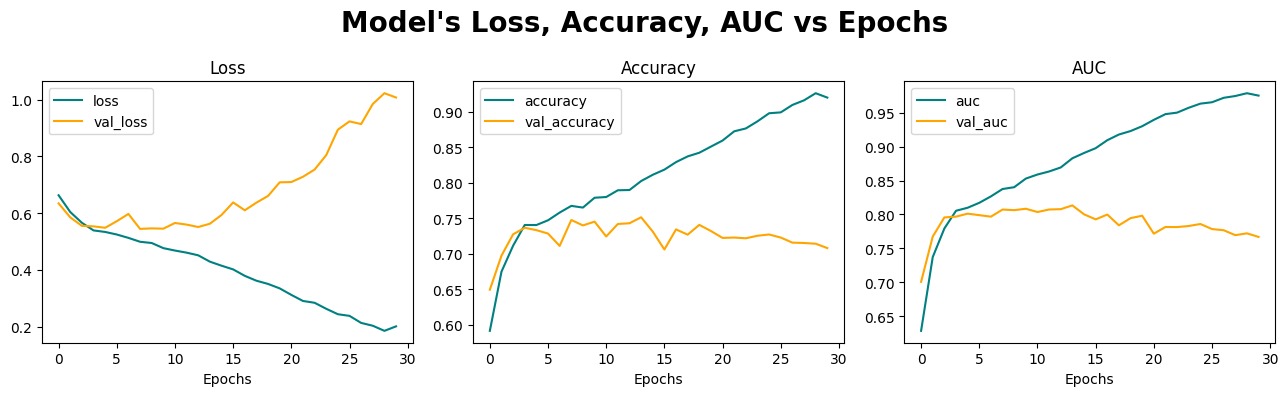

In [30]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(hist3.history['loss'], color='teal', label='loss')
axs[0].plot(hist3.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(hist3.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(hist3.history['auc_2'], color='teal', label='auc')
axs[2].plot(hist3.history['val_auc_2'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('CNNClassifier_model1_trainingMetrics.png', dpi = 300)
plt.show()

In [31]:
test_evaluate_model3 = model3.evaluate(test)

28/28 [==============================] - 1s 8ms/step - loss: 0.9999 - accuracy: 0.6847 - precision_2: 0.6655 - recall_2: 0.7568 - auc_2: 0.7493 - true_positives_2: 750.0000 - false_positives_2: 377.0000 - true_negatives_2: 592.0000 - false_negatives_2: 241.0000


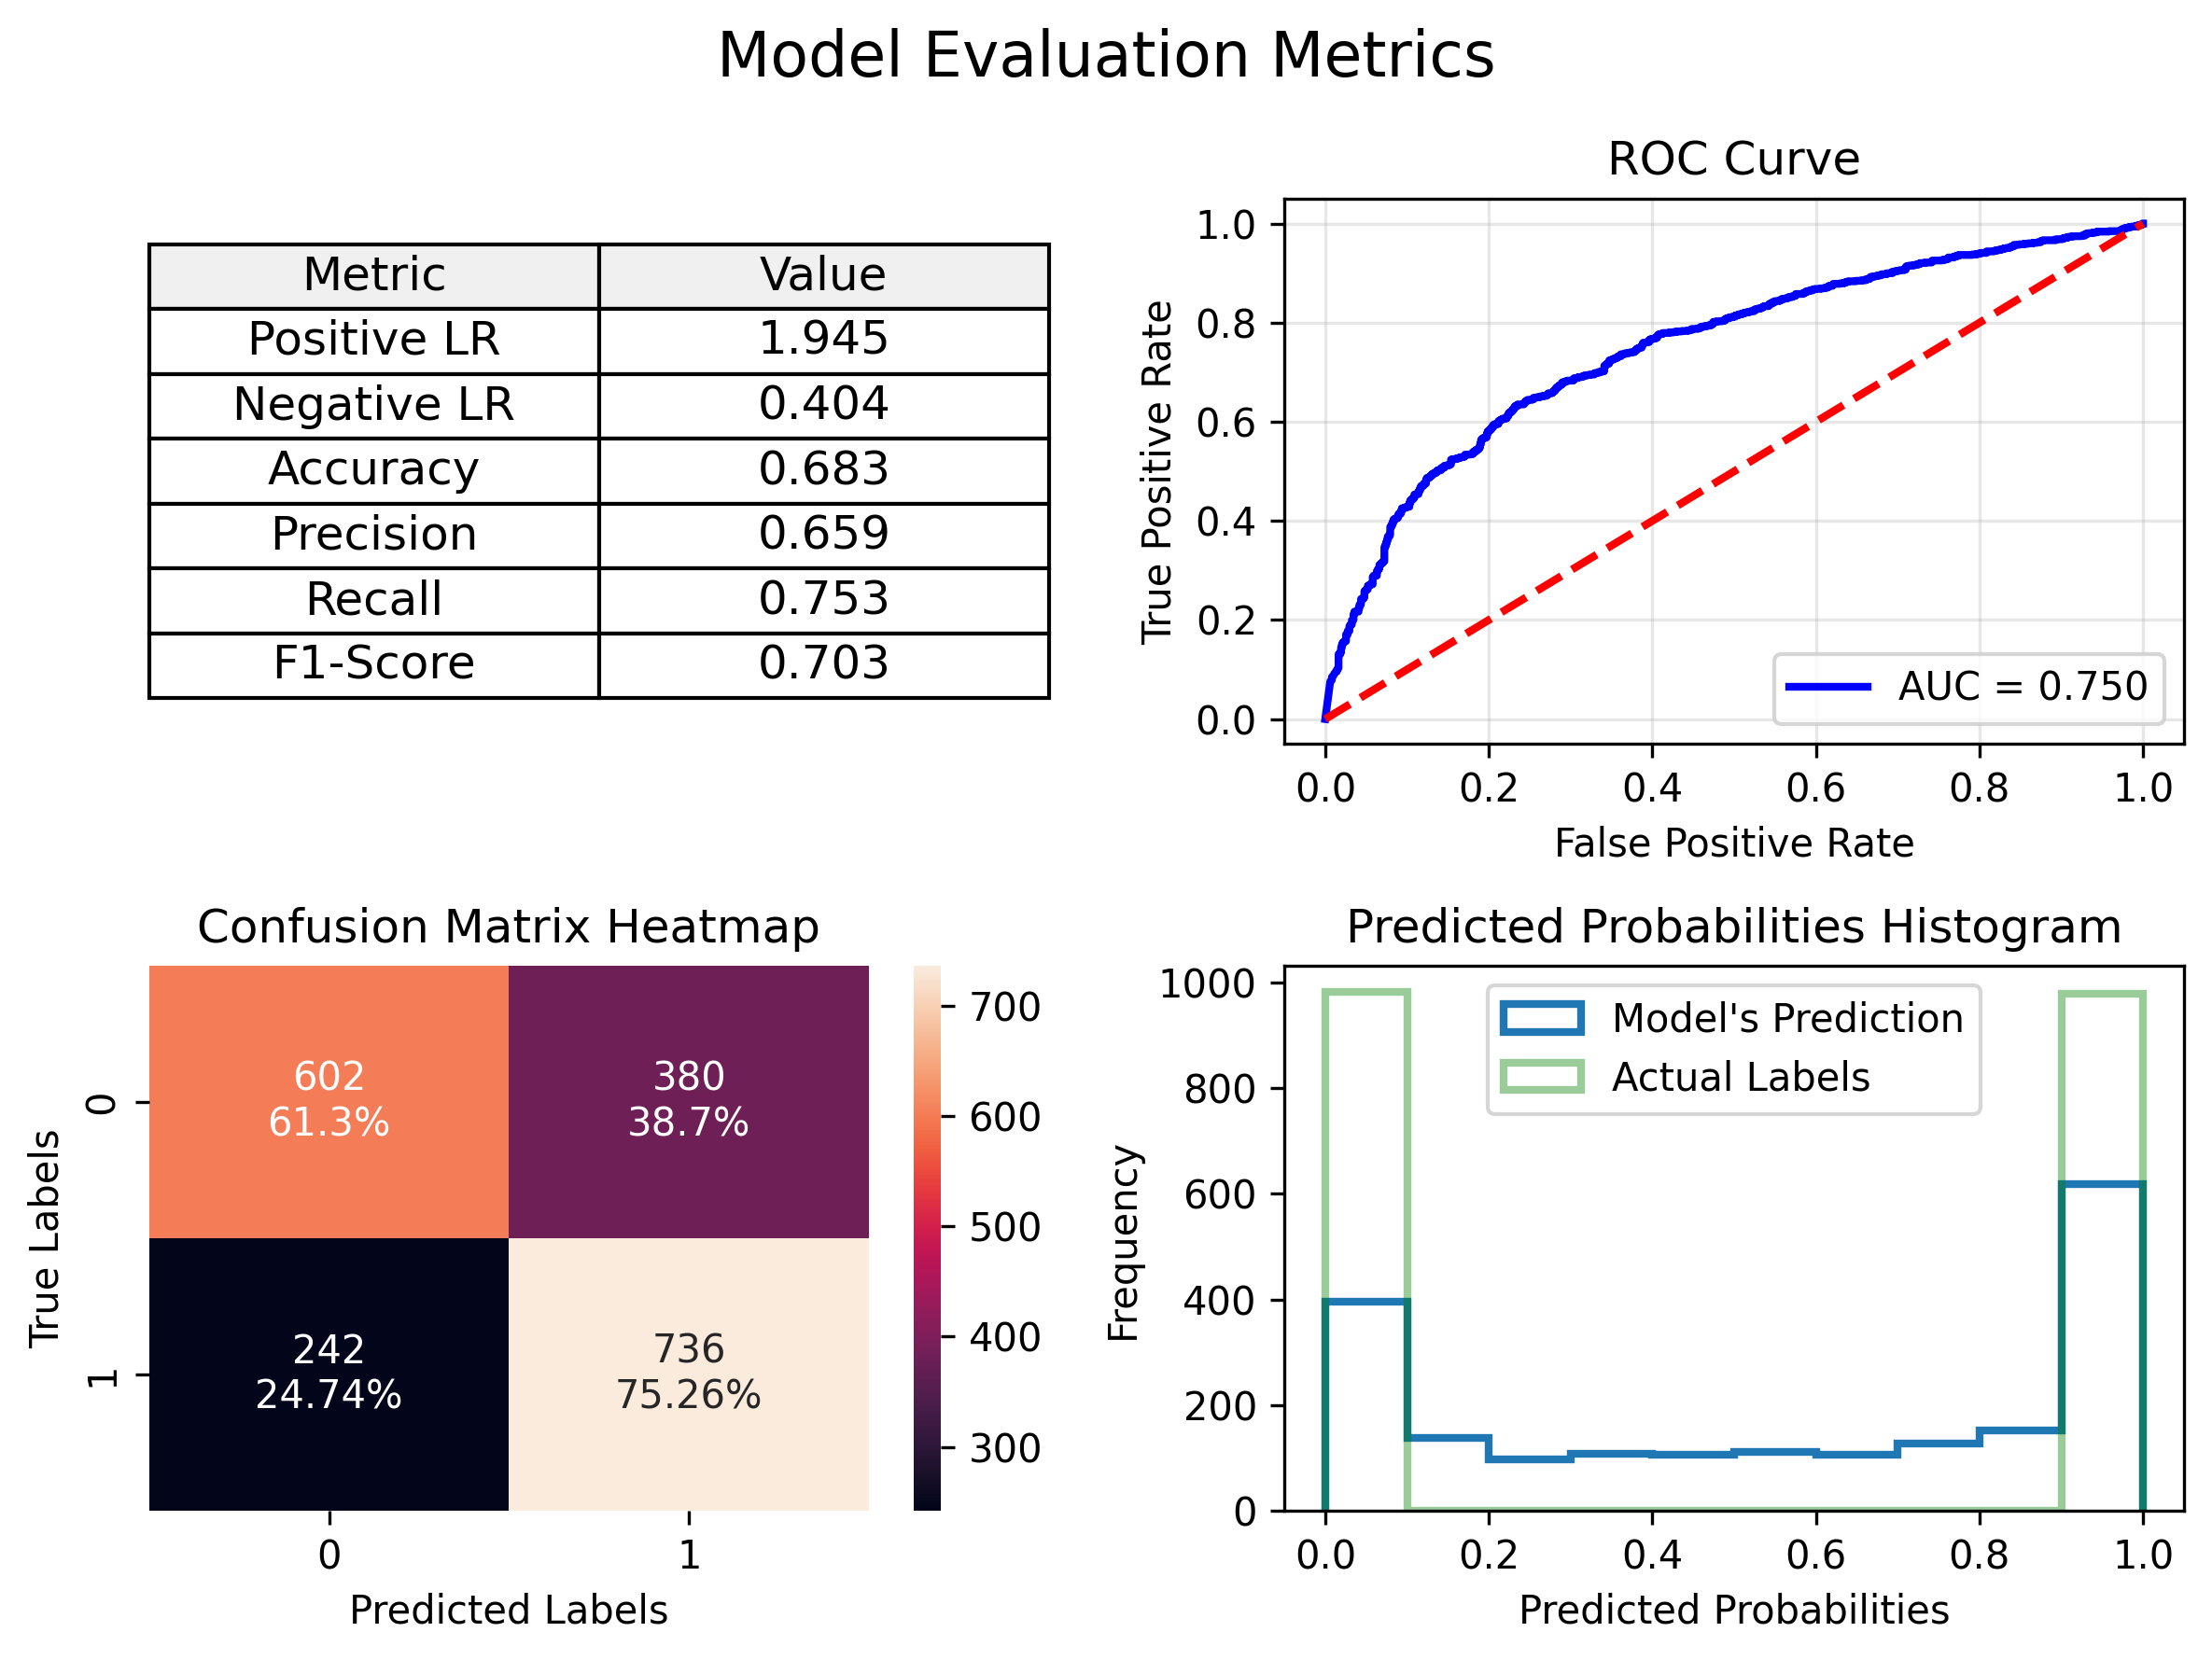

In [53]:
y_test_true, y_test_pred_prob = get_labels(model3, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'CNNModel3_Metrics.png')

# Model 4: Leaky ReLU

In [54]:
model_Leaky_ReLU = Sequential()

model_Leaky_ReLU.add(Conv2D(128, (5,5), 1, padding = 'same', activation='leaky_relu', input_shape=(50,50,3)))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model_Leaky_ReLU.add(Conv2D(64, (3,3), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Conv2D(32, (3,3), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model_Leaky_ReLU.add(Conv2D(16, (2,2), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Conv2D(8, (2,2), 1, activation='leaky_relu'))
model_Leaky_ReLU.add(AveragePooling2D(pool_size = (2,2)))

model_Leaky_ReLU.add(Flatten())

model_Leaky_ReLU.add(Dense(256, activation='leaky_relu'))
model_Leaky_ReLU.add(Dense(512, activation='leaky_relu'))
model_Leaky_ReLU.add(Dense(1, activation='sigmoid'))

In [55]:
model_Leaky_ReLU.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [56]:
logdir = '/teamspace/studios/this_studio/all/EFlow Images/model_tensorboard_logs/EFLow_Images_CNN_Classifier_model4LeakyReLU'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

histLeaky_ReLU = model_Leaky_ReLU.fit(train,
                 epochs = 30,
                 validation_data = val, 
                 callbacks = [tensorboard_callback])

Epoch 1/30
197/197 [==============================] - 11s 36ms/step - loss: 0.6644 - accuracy: 0.5956 - precision_3: 0.6125 - recall_3: 0.4984 - auc_3: 0.6276 - true_positives_3: 3402.0000 - false_positives_3: 2152.0000 - true_negatives_3: 4812.0000 - false_negatives_3: 3424.0000 - val_loss: 0.6522 - val_accuracy: 0.5959 - val_precision_3: 0.7846 - val_recall_3: 0.2975 - val_auc_3: 0.7109 - val_true_positives_3: 601.0000 - val_false_positives_3: 165.0000 - val_true_negatives_3: 1735.0000 - val_false_negatives_3: 1419.0000
Epoch 2/30
197/197 [==============================] - 7s 33ms/step - loss: 0.6067 - accuracy: 0.6683 - precision_3: 0.6792 - recall_3: 0.6253 - auc_3: 0.7323 - true_positives_3: 4269.0000 - false_positives_3: 2016.0000 - true_negatives_3: 4947.0000 - false_negatives_3: 2558.0000 - val_loss: 0.5925 - val_accuracy: 0.6987 - val_precision_3: 0.6951 - val_recall_3: 0.7241 - val_auc_3: 0.7608 - val_true_positives_3: 1441.0000 - val_false_positives_3: 632.0000 - val_true_ne

In [57]:
print(f"Best Obtained Loss: {histLeaky_ReLU.history['loss'][-1]}\n\
Best Obtained Accuracy: {histLeaky_ReLU.history['accuracy'][-1]*100:.2f}%\n\
Best Obtained Validation Accuracy: {histLeaky_ReLU.history['val_accuracy'][-1]*100:.2f}%")

Best Obtained Loss: 0.2809869050979614
Best Obtained Accuracy: 87.54%
Best Obtained Validation Accuracy: 69.08%


In [58]:
#Saving the model
# model_Leaky_ReLU.save(os.path.join('EFlow Images','EflowimageclassifierModel4_Leaky_ReLU.keras'))

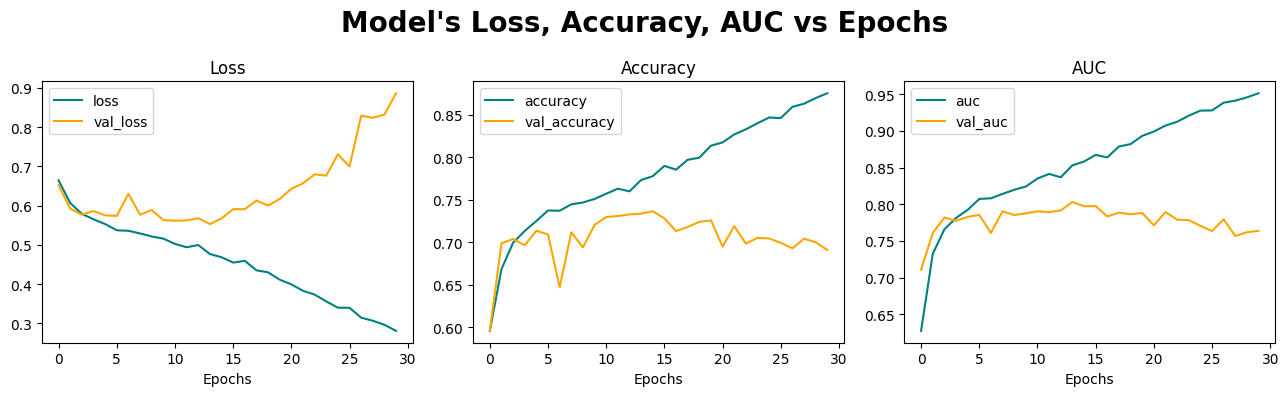

In [60]:
fig, axs = plt.subplots(1, 3, figsize = (13,4))

# Loss Plot
axs[0].plot(histLeaky_ReLU.history['loss'], color='teal', label='loss')
axs[0].plot(histLeaky_ReLU.history['val_loss'], color='orange', label='val_loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Loss')
axs[0].legend(loc="upper left")

# Accuracy Plot
axs[1].plot(histLeaky_ReLU.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(histLeaky_ReLU.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend(loc="upper left")

# AUC Plot
axs[2].plot(histLeaky_ReLU.history['auc_3'], color='teal', label='auc')
axs[2].plot(histLeaky_ReLU.history['val_auc_3'], color='orange', label='val_auc')
axs[2].set_xlabel('Epochs')
axs[2].set_title('AUC')
axs[2].legend(loc="upper left")

plt.suptitle("Model's Loss, Accuracy, AUC vs Epochs", fontsize = 20, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('CNNClassifier_model1_trainingMetrics.png', dpi = 300)
plt.show()

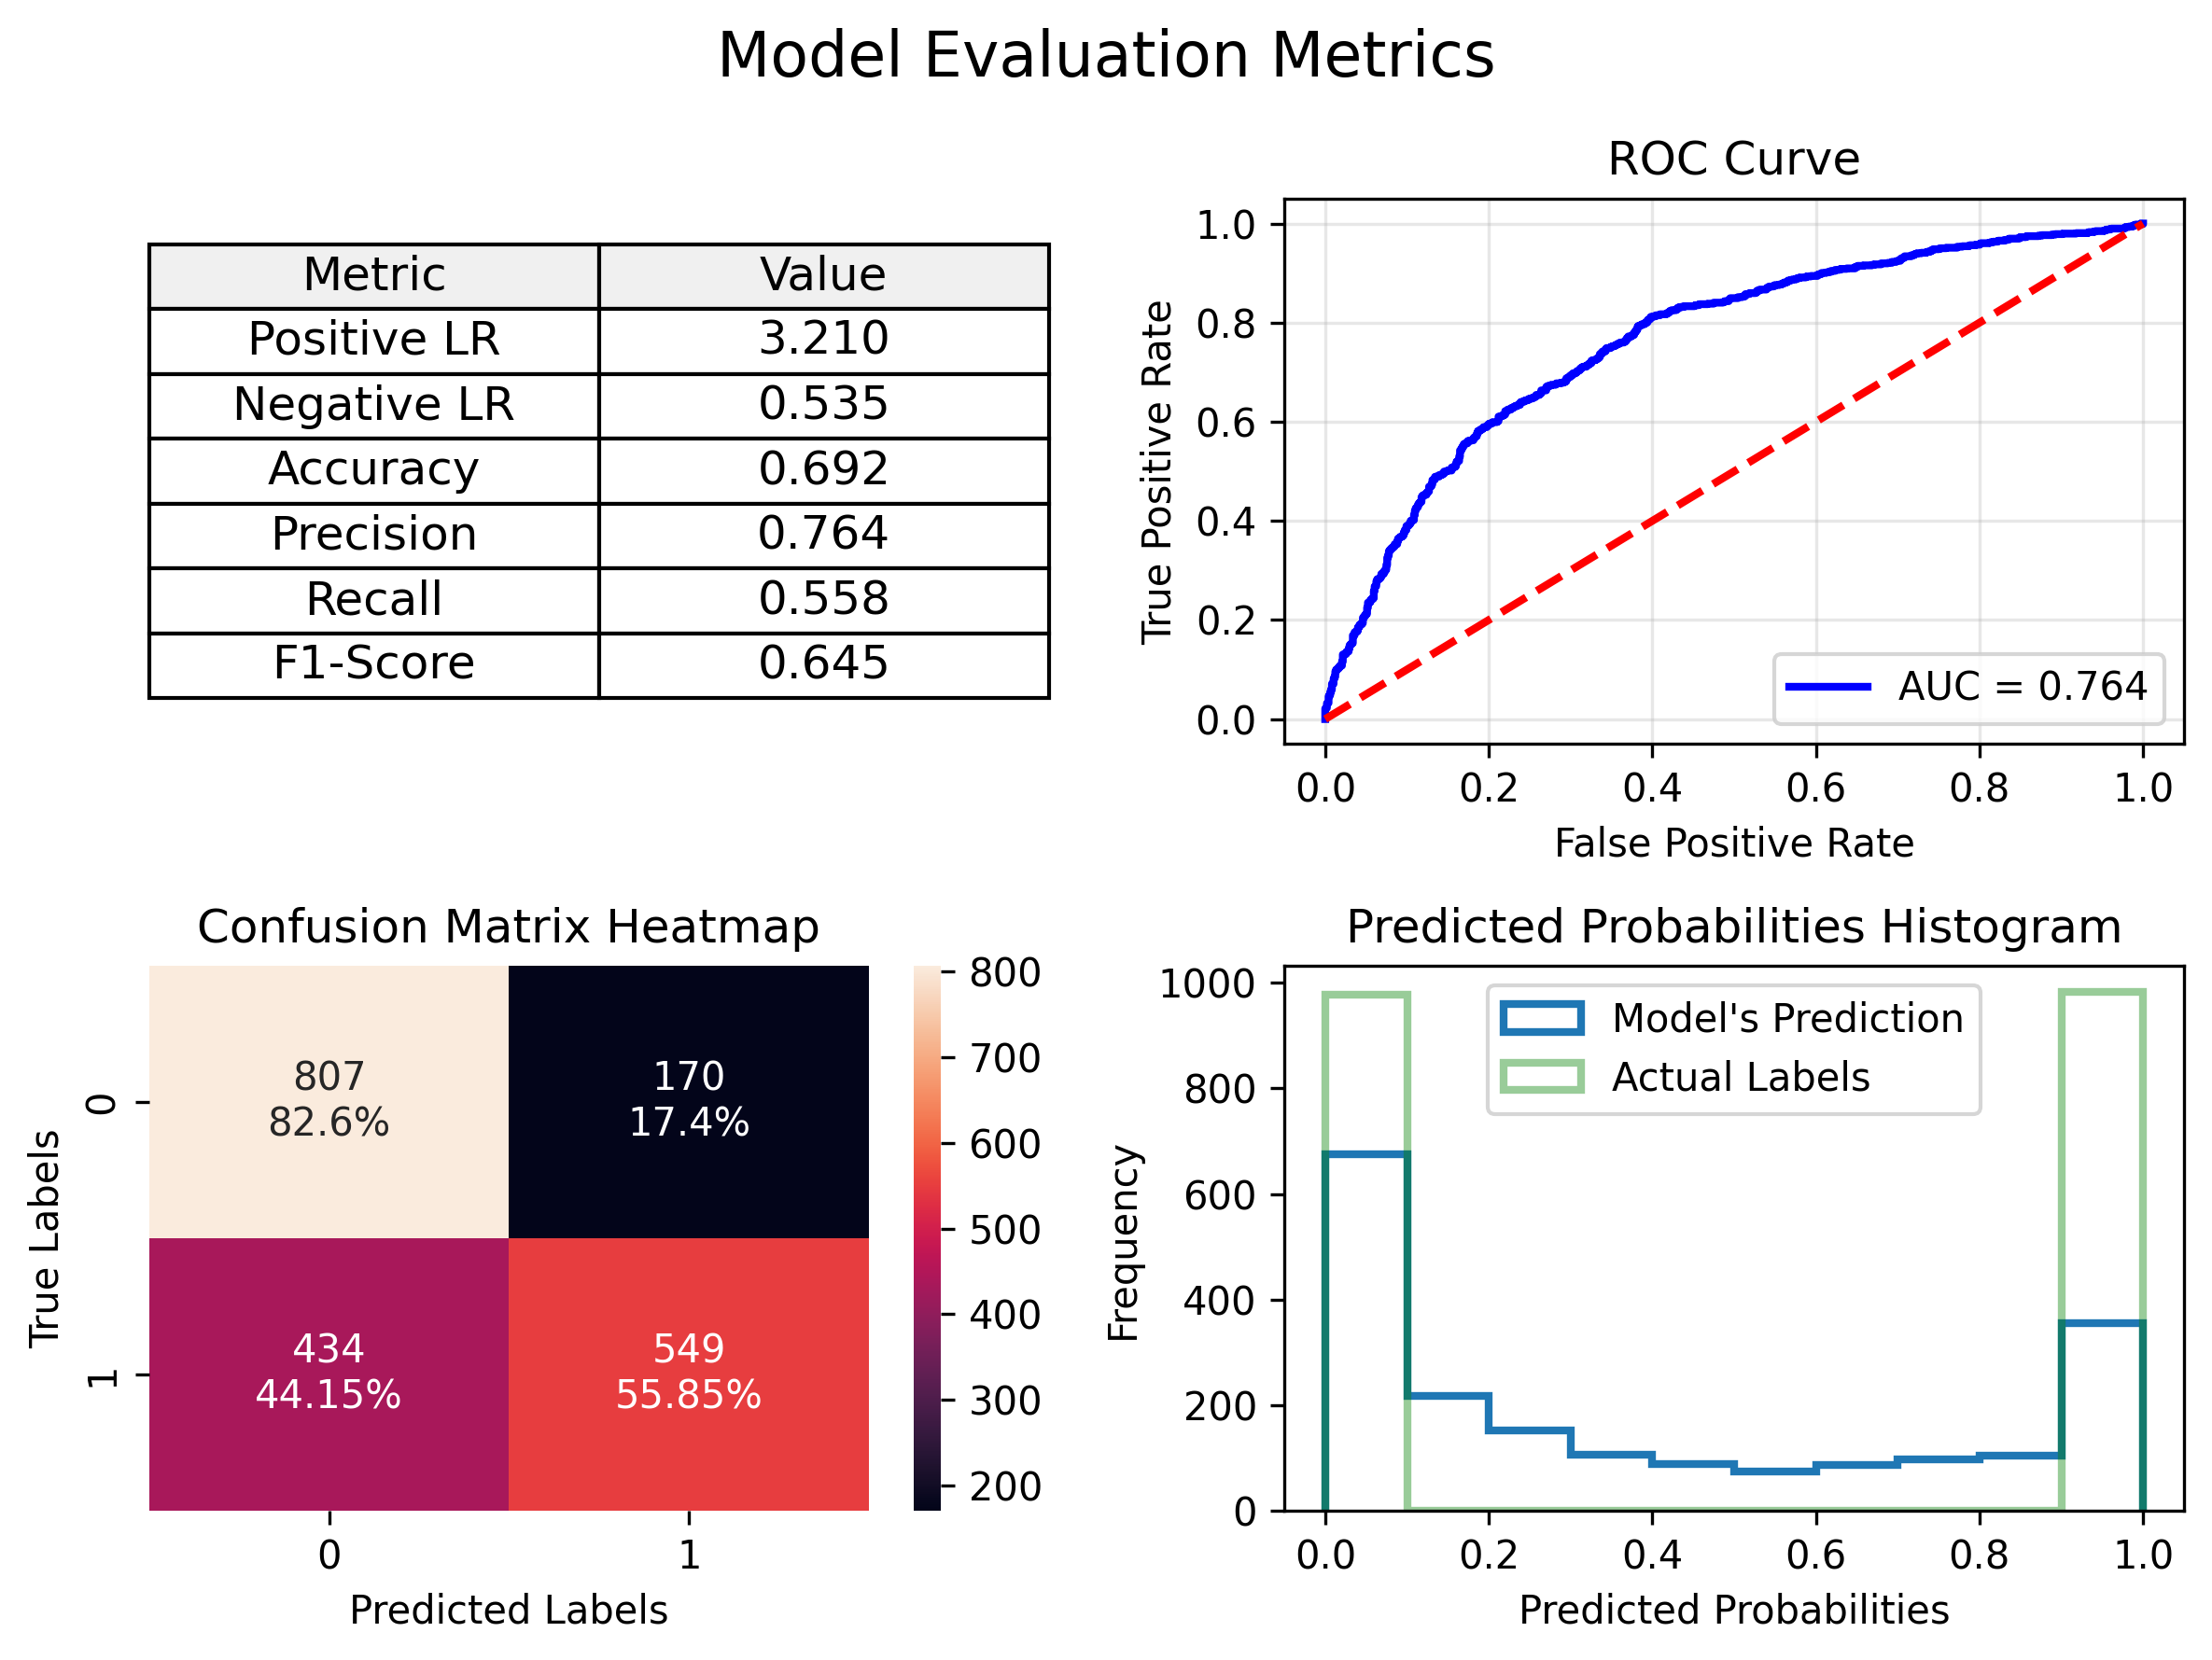

In [61]:
y_test_true, y_test_pred_prob = get_labels(model_Leaky_ReLU, test)
y_test_pred_label = [1 if (y_pred >= 0.5) else 0 for y_pred in y_test_pred_prob]
eval_model(y_test_true, y_test_pred_prob, y_test_pred_label, save_fig = False, save_fig_path = 'CNNModel4_Leaky_ReLU_Metrics.png')